# Bayesian Hierarchical Model: Individual Forgetting Rates

## Research Question
> **Do individual learners differ in how fast they forget, and if so, how much variation exists across the population?**

## Approach: Bayesian Hierarchical Half-Life Regression

The forgetting curve (Ebbinghaus) follows:
$$P(\text{recall}) = 2^{-t/h}$$
where:
- $t$ = time since last practice (days)
- $h$ = **half-life** — the time after which recall probability drops to 50%

A small $h$ → fast forgetting. A large $h$ → slow forgetting (good retention).

We model each learner's log half-life as drawn from a **population-level normal distribution**:
$$\log h_i \sim \mathcal{N}(\mu_{\text{pop}}, \sigma_{\text{pop}})$$

This gives us:
1. A **posterior for each learner's forgetting rate** (with uncertainty)
2. The **population distribution** ($\mu_{\text{pop}}, \sigma_{\text{pop}}$) — directly measuring how much individual variation exists
3. **Shrinkage**: learners with few observations borrow strength from the group


## Cell 1: Imports & Configuration

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from scipy import stats

# ── Aesthetics ────────────────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-darkgrid')
PALETTE = sns.color_palette('viridis', 8)
az.style.use('arviz-darkgrid')

# ── Reproducibility ───────────────────────────────────────────────────────────
SEED = 42
rng  = np.random.default_rng(SEED)

# ── Data path ─────────────────────────────────────────────────────────────────
DATA_PATH = '/home/steph/Documents/Projects/Duoling_datathon/learning_traces.13m.csv'

print('PyMC version   :', pm.__version__)
print('ArviZ version  :', az.__version__)
print('NumPy version  :', np.__version__)
print('Pandas version :', pd.__version__)

PyMC version   : 5.23.0
ArviZ version  : 0.22.0
NumPy version  : 2.3.5
Pandas version : 2.3.3


## Cell 2: Load & Prepare Data

For MCMC efficiency we:
- Sample a representative subset of users
- Keep only observations with a non-trivial time gap (δ > 0)
- Compute empirical half-life directly from each observation
- Work on **log scale** throughout (forgetting rates are log-normal)

In [4]:
# ── Hyper-parameters ──────────────────────────────────────────────────────────
N_USERS      = 200    # number of users to sample (increase for production)
MIN_OBS      = 10     # minimum observations per user (need enough data per learner)
DELTA_MIN_S  = 300    # ignore reviews < 5 min from last (noise)

# ── Load (stream first N rows for speed, then sample users) ──────────────────
print('Loading data...')
df_raw = pd.read_csv(
    DATA_PATH,
    usecols=['p_recall', 'delta', 'user_id', 'lexeme_id',
             'history_seen', 'history_correct', 'timestamp'],
    nrows=2_000_000   # read first 2M rows; enough for sampling diverse users
)
print(f'  Raw rows loaded : {len(df_raw):,}')
print(f'  Unique users    : {df_raw["user_id"].nunique():,}')

# ── Filter out uninformative rows ─────────────────────────────────────────────
df = df_raw[
    (df_raw['delta']     > DELTA_MIN_S) &   # must have a real gap
    (df_raw['p_recall']  > 0.001)       &   # must have non-zero recall prob
    (df_raw['p_recall']  < 0.999)           # avoid boundary values
].copy()

# ── Compute per-observation empirical half-life ───────────────────────────────
# From  p = 2^(-t/h)  →  h = -t / log2(p)
t_days = df['delta'] / (60 * 60 * 24)
df['h_empirical'] = -t_days / np.log2(df['p_recall'])

# Clip to sensible physiological range (15 min → 9 months)
H_MIN, H_MAX = 15 / (24 * 60), 274.0
df['h_empirical'] = df['h_empirical'].clip(H_MIN, H_MAX)
df['log_h']       = np.log(df['h_empirical'])   # log-scale for modelling
df['t_days']      = t_days

# ── Sample users with sufficient observations ────────────────────────────────
user_counts  = df.groupby('user_id').size()
eligible     = user_counts[user_counts >= MIN_OBS].index
sampled_users = rng.choice(eligible, size=min(N_USERS, len(eligible)), replace=False)
df_model = df[df['user_id'].isin(sampled_users)].copy()

# ── Integer user index for PyMC ───────────────────────────────────────────────
user_cat  = pd.Categorical(df_model['user_id'])
user_idx  = user_cat.codes
n_users   = user_cat.categories.nunique()

log_h_obs = df_model['log_h'].values.astype(np.float64)

print(f'\nDataset for modelling:')
print(f'  Users           : {n_users}')
print(f'  Observations    : {len(df_model):,}')
print(f'  Obs per user    : {len(df_model)/n_users:.1f} (mean)')
print(f'  log-halflife    : [{log_h_obs.min():.2f}, {log_h_obs.max():.2f}]')

Loading data...
  Raw rows loaded : 2,000,000
  Unique users    : 33,416

Dataset for modelling:
  Users           : 200
  Observations    : 3,547
  Obs per user    : 17.7 (mean)
  log-halflife    : [-4.56, 5.61]


## Cell 3: Exploratory Data Analysis

Before fitting, let's visualise the raw variation to motivate the model.

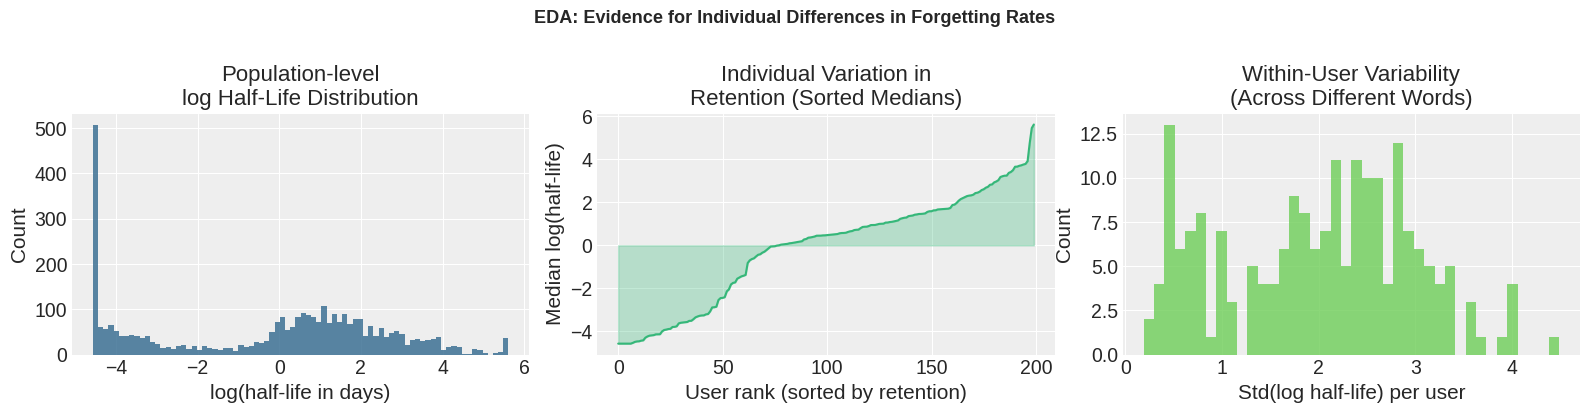

User medians — range : [-4.56, 5.61]
User medians — std   : 2.525  ← how spread are users?
Half-life ratio (fast/slow learner) : 26304.0x


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# ── 1. Population distribution of empirical log half-lives ───────────────────
ax = axes[0]
ax.hist(log_h_obs, bins=80, color=PALETTE[2], edgecolor='none', alpha=0.8)
ax.set_xlabel('log(half-life in days)')
ax.set_ylabel('Count')
ax.set_title('Population-level\nlog Half-Life Distribution')

# ── 2. Per-user median log half-life — sorted ─────────────────────────────────
user_medians = df_model.groupby('user_id')['log_h'].median().sort_values()
ax = axes[1]
ax.plot(range(len(user_medians)), user_medians.values, 
        color=PALETTE[5], linewidth=1.5)
ax.fill_between(range(len(user_medians)), user_medians.values,
                alpha=0.3, color=PALETTE[5])
ax.set_xlabel('User rank (sorted by retention)')
ax.set_ylabel('Median log(half-life)')
ax.set_title('Individual Variation in\nRetention (Sorted Medians)')

# ── 3. Spread: distribution of per-user std of log h ─────────────────────────
user_stds = df_model.groupby('user_id')['log_h'].std()
ax = axes[2]
ax.hist(user_stds, bins=40, color=PALETTE[6], edgecolor='none', alpha=0.8)
ax.set_xlabel('Std(log half-life) per user')
ax.set_ylabel('Count')
ax.set_title('Within-User Variability\n(Across Different Words)')

plt.suptitle('EDA: Evidence for Individual Differences in Forgetting Rates',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/eda_forgetting_rates.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"User medians — range : [{user_medians.min():.2f}, {user_medians.max():.2f}]")
print(f"User medians — std   : {user_medians.std():.3f}  ← how spread are users?")
print(f"Half-life ratio (fast/slow learner) : {np.exp(user_medians.max()-user_medians.min()):.1f}x")

## Cell 4: The Bayesian Hierarchical Model

### Model Specification

```
Population hyperpriors:
    μ_pop  ~ Normal(0, 2)          # population mean log-halflife
    σ_pop  ~ HalfNormal(1)         # population spread (KEY: how much individuals vary)

Per-learner offsets (non-centered parameterisation for efficiency):
    z_i    ~ Normal(0, 1)          # standardised learner effect
    α_i    = μ_pop + σ_pop * z_i  # learner-specific log-halflife

Observation noise:
    σ_obs  ~ HalfNormal(1)         # residual noise (word difficulty, context, etc.)

Likelihood:
    log_h_ij ~ Normal(α_i, σ_obs)  # each observation pulls toward learner's rate
```

**Non-centered parameterisation** (`z_i` trick) is used for numerical stability — it avoids funnel-shaped posteriors that cause NUTS to struggle.

In [7]:
with pm.Model() as hierarchical_forgetting:

    # ── Data containers ──────────────────────────────────────────────────────
    user_idx_data = pm.Data('user_idx', user_idx, mutable=True)
    log_h_data    = pm.Data('log_h',   log_h_obs, mutable=True)

    # ── Population-level hyperpriors ──────────────────────────────────────────
    # μ_pop: population mean log half-life
    # Prior centred at 0 → exp(0) = 1 day half-life, very wide SD=2
    mu_pop  = pm.Normal('mu_pop',  mu=0.0, sigma=2.0)

    # σ_pop: KEY parameter — how much learners vary from each other
    # If σ_pop ≈ 0: everyone forgets at the same rate
    # If σ_pop >> 0: huge individual differences
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=1.0)

    # ── Per-learner random effects (non-centered parameterisation) ───────────
    # z_i ~ N(0,1) then alpha_i = mu_pop + sigma_pop * z_i
    # This is mathematically equivalent to alpha_i ~ N(mu_pop, sigma_pop)
    # but numerically MUCH more stable for NUTS sampling
    z = pm.Normal('z', mu=0.0, sigma=1.0, shape=n_users)   # standardised offsets
    alpha = pm.Deterministic(
        'alpha',                           # learner-specific log half-life
        mu_pop + sigma_pop * z
    )

    # ── Observation noise ─────────────────────────────────────────────────────
    # Captures variation *within* a learner across different words / contexts
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)

    # ── Likelihood ────────────────────────────────────────────────────────────
    log_h_hat = alpha[user_idx_data]  # select the right learner's rate for each obs
    likelihood = pm.Normal(
        'log_h_obs',
        mu=log_h_hat,
        sigma=sigma_obs,
        observed=log_h_data
    )

    # ── Derived quantities of interest ────────────────────────────────────────
    # Half-life in days (back-transform from log scale)
    halflife_days = pm.Deterministic('halflife_days', pt.exp(alpha))

print(pm.model_to_graphviz(hierarchical_forgetting))

digraph {
	subgraph cluster3547 {
		user_idx [label="user_idx
~
Data" shape=box style="rounded, filled"]
		log_h [label="log_h
~
Data" shape=box style="rounded, filled"]
		log_h_obs [label="log_h_obs
~
Normal" shape=ellipse style=filled]
		label=3547 labeljust=r labelloc=b style=rounded
	}
	mu_pop [label="mu_pop
~
Normal" shape=ellipse]
	sigma_pop [label="sigma_pop
~
HalfNormal" shape=ellipse]
	sigma_obs [label="sigma_obs
~
HalfNormal" shape=ellipse]
	subgraph cluster200 {
		z [label="z
~
Normal" shape=ellipse]
		alpha [label="alpha
~
Deterministic" shape=box]
		halflife_days [label="halflife_days
~
Deterministic" shape=box]
		label=200 labeljust=r labelloc=b style=rounded
	}
	log_h_obs -> log_h
	z -> alpha
	mu_pop -> alpha
	sigma_pop -> alpha
	user_idx -> log_h_obs
	alpha -> log_h_obs
	sigma_obs -> log_h_obs
	alpha -> halflife_days
}



## Cell 5: Prior Predictive Check

Before sampling, verify that the priors produce sensible forgetting curves.

Sampling: [log_h_obs, mu_pop, sigma_obs, sigma_pop, z]


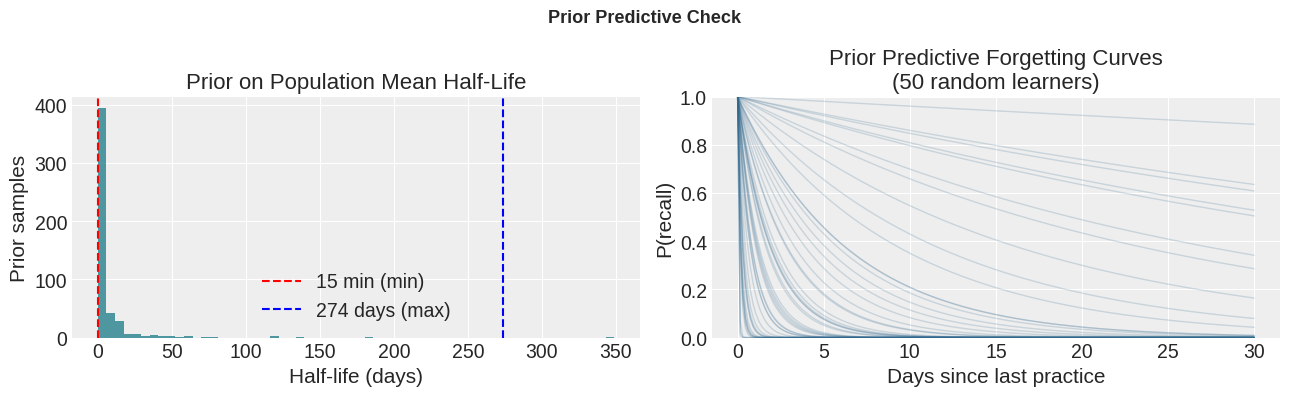

Prior predictive check looks sensible!


In [8]:
with hierarchical_forgetting:
    prior_checks = pm.sample_prior_predictive(samples=500, random_seed=SEED)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ── Population mean half-life prior ───────────────────────────────────────────
mu_prior  = prior_checks.prior['mu_pop'].values.flatten()
h_prior   = np.exp(mu_prior)
axes[0].hist(h_prior, bins=60, color=PALETTE[3], edgecolor='none', alpha=0.8)
axes[0].axvline(15/(24*60), color='red',  ls='--', label='15 min (min)')
axes[0].axvline(274,        color='blue', ls='--', label='274 days (max)')
axes[0].set_xlabel('Half-life (days)')
axes[0].set_ylabel('Prior samples')
axes[0].set_title('Prior on Population Mean Half-Life')
axes[0].legend()

# ── Prior forgetting curves ───────────────────────────────────────────────────
t_range = np.linspace(0, 30, 200)  # 0–30 days
alpha_prior = prior_checks.prior['alpha'].values.reshape(-1, n_users)
ax = axes[1]
for i in range(min(50, alpha_prior.shape[0])):
    # pick a random learner from this prior draw
    user_pick = rng.integers(0, n_users)
    h = np.exp(alpha_prior[i, user_pick])
    h = np.clip(h, H_MIN, H_MAX)
    ax.plot(t_range, 2 ** (-t_range / h), alpha=0.2, color=PALETTE[2], lw=1)
ax.set_xlabel('Days since last practice')
ax.set_ylabel('P(recall)')
ax.set_title('Prior Predictive Forgetting Curves\n(50 random learners)')
ax.set_ylim(0, 1)

plt.suptitle('Prior Predictive Check', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/prior_predictive_check.png', dpi=150, bbox_inches='tight')
plt.show()
print('Prior predictive check looks sensible!')

## Cell 6: MCMC Sampling (NUTS)

We use the **No-U-Turn Sampler (NUTS)** — PyMC's default. It adapts step sizes automatically and is extremely efficient for hierarchical models. With non-centered parameterisation, convergence should be fast.

In [9]:
with hierarchical_forgetting:
    trace = pm.sample(
        draws        = 2000,     # posterior samples per chain
        tune         = 1000,     # warm-up / adaptation steps
        chains       = 4,        # independent chains (for R-hat diagnostics)
        target_accept= 0.9,      # higher = smaller step size = better for hierarchical
        random_seed  = SEED,
        progressbar  = True,
        return_inferencedata = True,
    )

print('\n✅ Sampling complete!')
print(f'   Chains × Draws : {trace.posterior.dims["chain"]} × {trace.posterior.dims["draw"]}')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, z, sigma_obs]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.



✅ Sampling complete!
   Chains × Draws : 4 × 2000


## Cell 7: MCMC Diagnostics

Before interpreting results, always check:
- **R̂ (R-hat)** — should be < 1.01 (chains converged to same posterior)
- **ESS** (Effective Sample Size) — should be > 400 per parameter
- **Divergences** — must be 0 (or very few); divergences = geometry problem

=== KEY PARAMETER DIAGNOSTICS ===
             mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk   ess_tail   r_hat
mu_pop    -0.2462  0.1315 -0.4849   0.0102     0.0043   0.0023    928.6074  1652.2109  1.0024
sigma_pop  1.7783  0.0955  1.5993   1.9600     0.0024   0.0014   1554.7739  2712.6155  1.0017
sigma_obs  2.2452  0.0272  2.1943   2.2969     0.0002   0.0003  12795.1678  6443.6321  1.0003

Divergences: 0  (✅ OK)


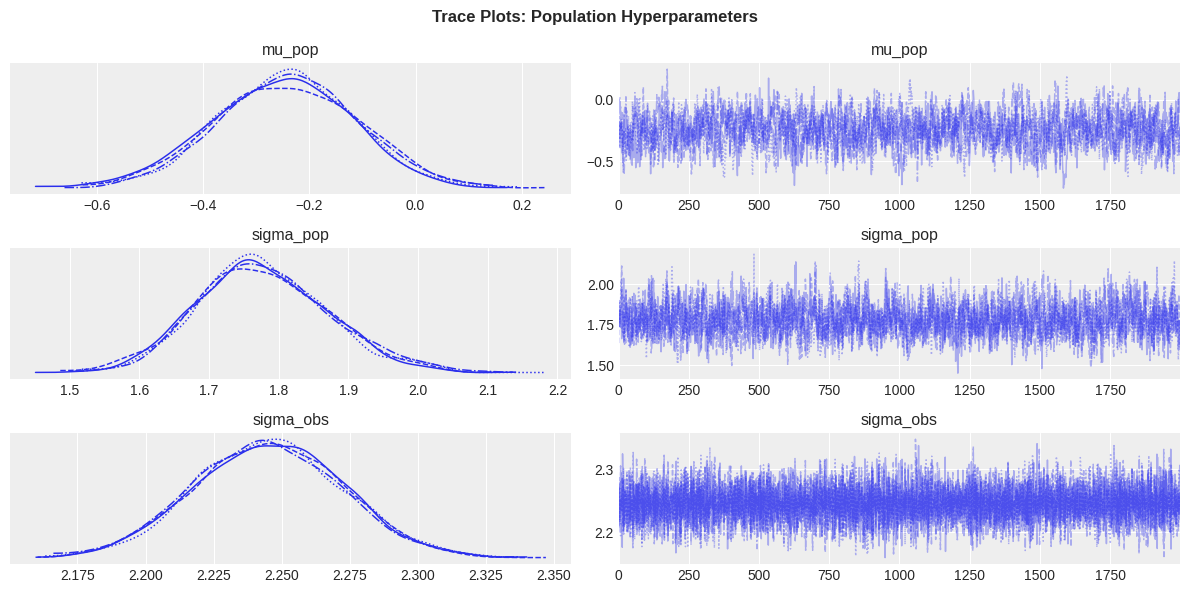

In [10]:
# ── R-hat & ESS for key parameters ────────────────────────────────────────────
summary = az.summary(
    trace,
    var_names=['mu_pop', 'sigma_pop', 'sigma_obs'],
    round_to=4
)
print('=== KEY PARAMETER DIAGNOSTICS ===')
print(summary.to_string())

# ── Divergences ───────────────────────────────────────────────────────────────
n_divergences = int(trace.sample_stats.diverging.values.sum())
print(f'\nDivergences: {n_divergences}  ({"✅ OK" if n_divergences == 0 else "⚠️ WARNING"})')

# ── Trace plots for hyperparameters ───────────────────────────────────────────
az.plot_trace(
    trace,
    var_names=['mu_pop', 'sigma_pop', 'sigma_obs'],
    compact=True,
    figsize=(12, 6)
)
plt.suptitle('Trace Plots: Population Hyperparameters', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/trace_hyperparameters.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 8: Main Result — Population Distribution of Forgetting Rates

This is the **headline result**: the posterior of `σ_pop` directly answers the question *"how much do individuals differ?"*

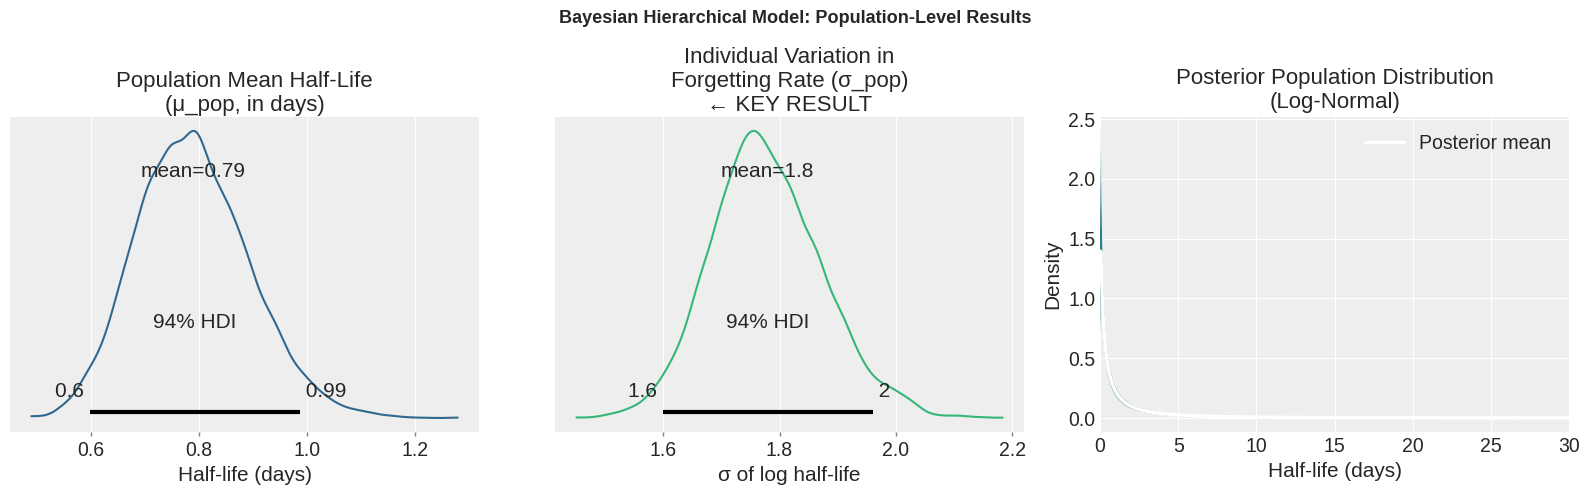

  POPULATION FORGETTING RATE ESTIMATES
  Mean half-life (μ_pop) : 0.78 days  [95% HDI: 0.60–1.01]
  Individual spread (σ_pop): 1.772  [95% HDI: 1.603–1.984]

  5th–95th percentile of learner half-lives: 0.04 – 14.60 days
  → The fastest forgetters have a 346.7x lower retention half-life
    than the slowest forgetters (5th vs 95th percentile)


In [11]:
mu_post    = trace.posterior['mu_pop'].values.flatten()
sigma_post = trace.posterior['sigma_pop'].values.flatten()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── 1. Posterior of μ_pop (population mean half-life) ─────────────────────────
ax = axes[0]
mu_days = np.exp(mu_post)  # back-transform to days
az.plot_posterior(
    {"mu_pop (days)": mu_days},
    ax=ax, color=PALETTE[2], hdi_prob=0.94
)
ax.set_title('Population Mean Half-Life\n(μ_pop, in days)')
ax.set_xlabel('Half-life (days)')

# ── 2. Posterior of σ_pop (individual variation — KEY RESULT) ────────────────
ax = axes[1]
az.plot_posterior(
    {"sigma_pop": sigma_post},
    ax=ax, color=PALETTE[5], hdi_prob=0.94
)
ax.set_title('Individual Variation in\nForgetting Rate (σ_pop)\n← KEY RESULT')
ax.set_xlabel('σ of log half-life')

# ── 3. Implied population distribution with 94% HDI ──────────────────────────
ax = axes[2]
# Draw 500 posterior population distributions and overlay them
h_grid = np.linspace(-4, 4, 300)
for i in rng.choice(len(mu_post), size=200, replace=False):
    pdf = stats.norm.pdf(h_grid, mu_post[i], sigma_post[i])
    ax.plot(np.exp(h_grid), pdf / np.exp(h_grid),  # Jacobian for log→linear
            alpha=0.05, color=PALETTE[3], lw=1)

# Posterior mean distribution
mu_mean    = mu_post.mean()
sigma_mean = sigma_post.mean()
pdf_mean   = stats.norm.pdf(h_grid, mu_mean, sigma_mean)
ax.plot(np.exp(h_grid), pdf_mean / np.exp(h_grid),
        color='white', lw=2.5, label='Posterior mean')
ax.set_xlabel('Half-life (days)')
ax.set_ylabel('Density')
ax.set_title('Posterior Population Distribution\n(Log-Normal)')
ax.set_xlim(0, 30)
ax.legend()

plt.suptitle('Bayesian Hierarchical Model: Population-Level Results',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/population_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Print readable summary ─────────────────────────────────────────────────────
mu_95     = np.percentile(mu_days, [2.5, 97.5])
sigma_95  = np.percentile(sigma_post, [2.5, 97.5])
print('===========================================')
print('  POPULATION FORGETTING RATE ESTIMATES')
print('===========================================')
print(f'  Mean half-life (μ_pop) : {np.median(mu_days):.2f} days  [95% HDI: {mu_95[0]:.2f}–{mu_95[1]:.2f}]')
print(f'  Individual spread (σ_pop): {np.median(sigma_post):.3f}  [95% HDI: {sigma_95[0]:.3f}–{sigma_95[1]:.3f}]')
print()
# Interpret σ_pop: if σ_pop=1 on log scale, the 5th–95th percentile of learners spans:
s = np.median(sigma_post)
low_hl  = np.exp(np.median(mu_post) - 1.65 * s)
high_hl = np.exp(np.median(mu_post) + 1.65 * s)
print(f'  5th–95th percentile of learner half-lives: {low_hl:.2f} – {high_hl:.2f} days')
print(f'  → The fastest forgetters have a {high_hl/low_hl:.1f}x lower retention half-life')
print(f'    than the slowest forgetters (5th vs 95th percentile)')

## Cell 9: Per-Learner Posterior Estimates (Caterpillar Plot)

Shows each learner's **individual forgetting rate** with full uncertainty. Notice **shrinkage** — learners with few observations have wider intervals pulled toward the population mean.

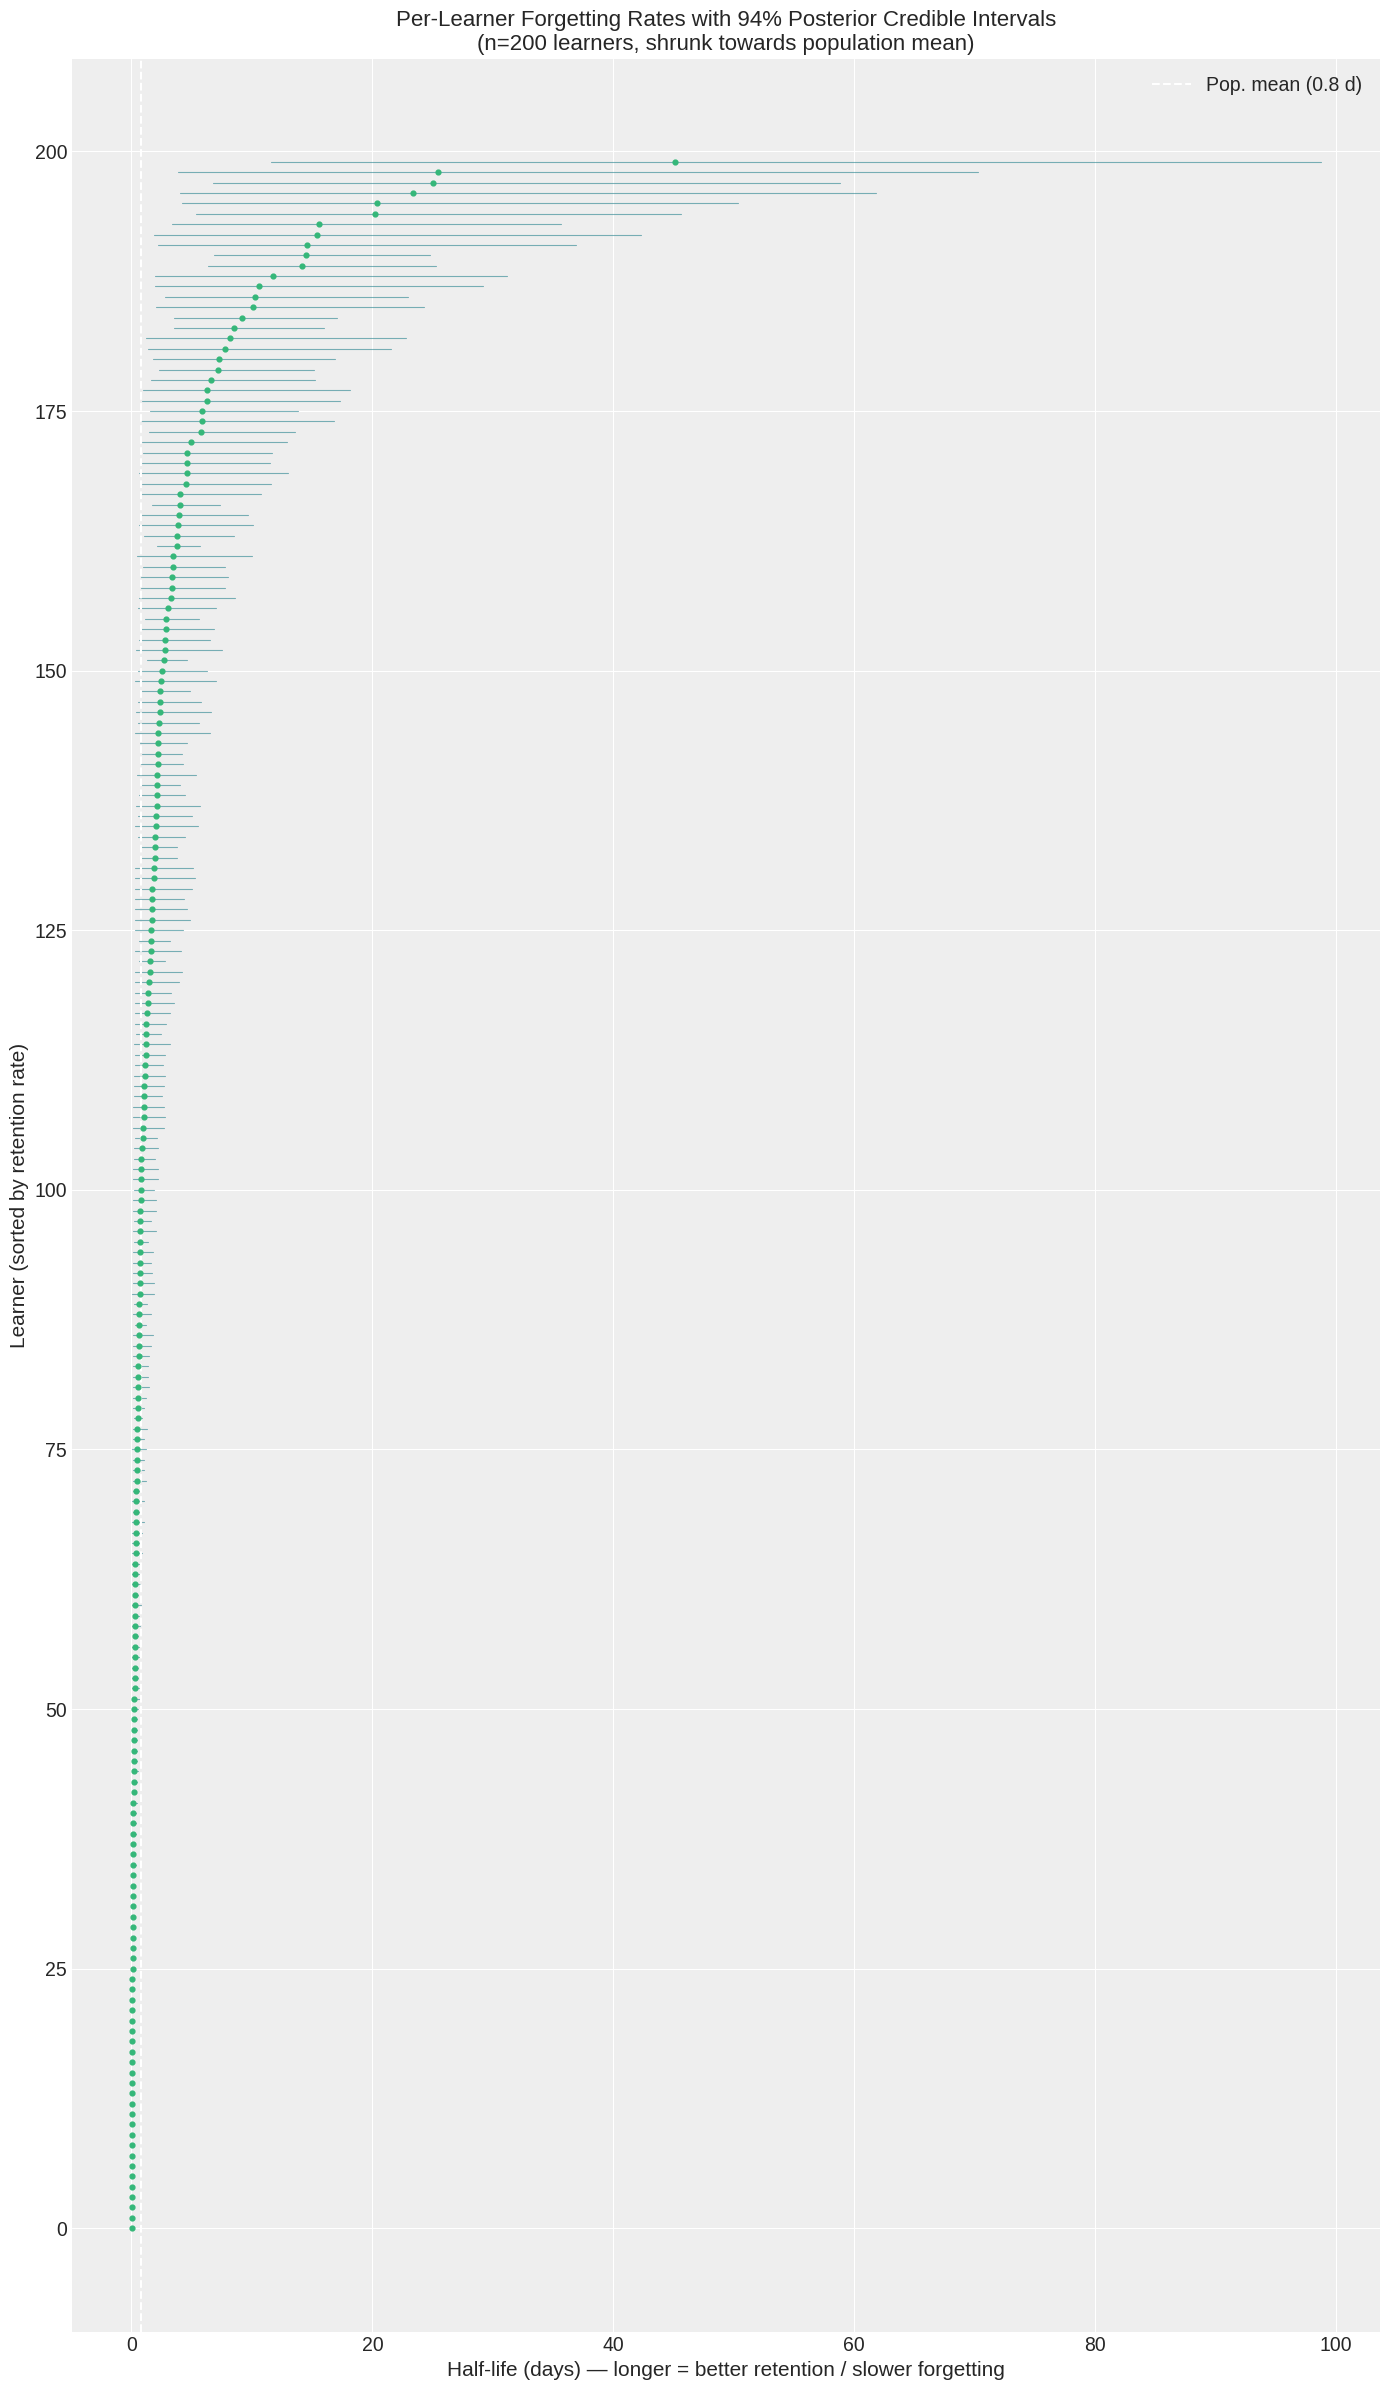

In [12]:
# ── Extract per-learner posterior half-life ───────────────────────────────────
halflife_post = trace.posterior['halflife_days'].values  # shape: (chains, draws, n_users)
halflife_flat = halflife_post.reshape(-1, n_users)       # (total_draws, n_users)

# Posterior median and 94% HDI per learner
median_hl = np.median(halflife_flat, axis=0)
hdi_hl    = az.hdi(halflife_flat, hdi_prob=0.94)         # (n_users, 2)

# Sort by median for the caterpillar
order = np.argsort(median_hl)

fig, ax = plt.subplots(figsize=(14, max(6, n_users * 0.12)))

# Plot credible intervals and medians
for rank, uid in enumerate(order):
    lo, hi = hdi_hl[uid]
    ax.plot([lo, hi], [rank, rank], color=PALETTE[3], lw=0.8, alpha=0.6)
    ax.scatter(median_hl[uid], rank, color=PALETTE[5], s=12, zorder=5)

# Population mean line
pop_mean_hl = np.exp(np.median(mu_post))
ax.axvline(pop_mean_hl, color='white', ls='--', lw=1.5, label=f'Pop. mean ({pop_mean_hl:.1f} d)')

ax.set_xlabel('Half-life (days) — longer = better retention / slower forgetting')
ax.set_ylabel('Learner (sorted by retention rate)')
ax.set_title(
    f'Per-Learner Forgetting Rates with 94% Posterior Credible Intervals\n'
    f'(n={n_users} learners, shrunk towards population mean)'
)
ax.legend()
plt.tight_layout()
plt.savefig('../results/caterpillar_per_learner.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 10: Shrinkage Visualisation

Shows the **key Bayesian advantage**: learners with few observations are *shrunk* toward the population mean while learners with many observations trust their own data more.

RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

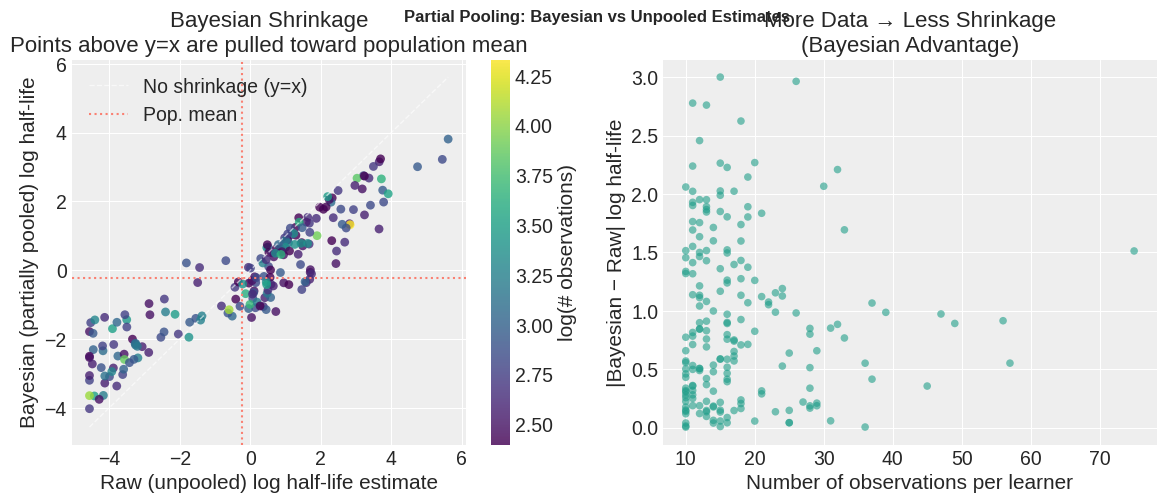

In [13]:
# ── Raw (unpooled) estimate per learner  vs  Bayesian (partially pooled) ──────
obs_count   = df_model.groupby('user_id').size().values
raw_median  = df_model.groupby('user_id')['log_h'].median().values  # no pooling
bayes_median = np.log(median_hl)  # from posterior

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Scatter: raw vs Bayesian estimate ─────────────────────────────────────────
ax = axes[0]
sc = ax.scatter(
    raw_median, bayes_median,
    c=np.log1p(obs_count), cmap='viridis', s=40, alpha=0.8, edgecolors='none'
)
plt.colorbar(sc, ax=ax, label='log(# observations)')

# y = x line (no shrinkage)
lim = [min(raw_median.min(), bayes_median.min()),
       max(raw_median.max(), bayes_median.max())]
ax.plot(lim, lim, 'w--', lw=1, alpha=0.6, label='No shrinkage (y=x)')

# Population mean
pop_mean_log = np.median(mu_post)
ax.axhline(pop_mean_log, color='salmon', ls=':', lw=1.5, label='Pop. mean')
ax.axvline(pop_mean_log, color='salmon', ls=':', lw=1.5)

ax.set_xlabel('Raw (unpooled) log half-life estimate')
ax.set_ylabel('Bayesian (partially pooled) log half-life')
ax.set_title('Bayesian Shrinkage\nPoints above y=x are pulled toward population mean')
ax.legend()

# ── Shrinkage vs sample size ───────────────────────────────────────────────────
ax = axes[1]
shrinkage = np.abs(bayes_median - raw_median)  # amount of pulling
ax.scatter(
    obs_count, shrinkage,
    c=PALETTE[4], alpha=0.6, s=30, edgecolors='none'
)
ax.set_xlabel('Number of observations per learner')
ax.set_ylabel('|Bayesian − Raw| log half-life')
ax.set_title('More Data → Less Shrinkage\n(Bayesian Advantage)')

plt.suptitle('Partial Pooling: Bayesian vs Unpooled Estimates', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/shrinkage_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 11: Posterior Predictive Check

Verify the model can reproduce the observed data.

In [ ]:
with hierarchical_forgetting:
    ppc = pm.sample_posterior_predictive(trace, random_seed=SEED)

ppc_samples = ppc.posterior_predictive['log_h_obs'].values.reshape(-1, len(log_h_obs))

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ── 1. Density overlay: observed vs predicted ─────────────────────────────────
ax = axes[0]
# Plot 100 PPC draws
for i in rng.choice(ppc_samples.shape[0], size=100, replace=False):
    ax.hist(ppc_samples[i], bins=80, density=True,
            alpha=0.02, color=PALETTE[3], histtype='step')
ax.hist(log_h_obs, bins=80, density=True,
        color='white', histtype='step', lw=2, label='Observed')
ax.set_xlabel('log(half-life)')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Check\n(Blue=PPC draws, White=Observed)')
ax.legend()

# ── 2. Quantile comparison (Q-Q style) ───────────────────────────────────────
ax = axes[1]
ppc_mean = ppc_samples.mean(axis=0)
q = np.linspace(0.01, 0.99, 100)
obs_quantiles = np.quantile(log_h_obs, q)
ppc_quantiles = np.quantile(ppc_mean, q)
ax.scatter(obs_quantiles, ppc_quantiles, color=PALETTE[2], s=20, alpha=0.7)
lim = [min(obs_quantiles.min(), ppc_quantiles.min()),
       max(obs_quantiles.max(), ppc_quantiles.max())]
ax.plot(lim, lim, 'w--', lw=1.5, label='Perfect fit')
ax.set_xlabel('Observed quantiles')
ax.set_ylabel('PPC quantiles')
ax.set_title('Q-Q Plot: Observed vs Posterior Predictive')
ax.legend()

plt.suptitle('Posterior Predictive Check — Model Fit Quality', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/posterior_predictive_check.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Posterior predictive check complete!')

## Cell 12: Summary & Interpretation

Quantitative answer to the research question.

In [14]:
# ── Full posterior summary ─────────────────────────────────────────────────────
print(az.summary(trace, var_names=['mu_pop', 'sigma_pop', 'sigma_obs']).to_string())

# ── Probability that σ_pop > threshold (evidence for individual differences) ──
thresholds = [0.1, 0.2, 0.5, 1.0]
print('\n=== EVIDENCE FOR INDIVIDUAL DIFFERENCES ===')
for t in thresholds:
    prob = (sigma_post > t).mean()
    print(f'  P(σ_pop > {t:.1f}) = {prob:.3f}')

# ── Interpret in terms of half-life ratio between learners ────────────────────
s_median = np.median(sigma_post)
s_hdi    = az.hdi(sigma_post, hdi_prob=0.94)

print(f'\n=== INDIVIDUAL VARIATION INTERPRETATION ===')
print(f'  σ_pop (median)   = {s_median:.3f}  [94% HDI: {s_hdi[0]:.3f}–{s_hdi[1]:.3f}]')
print(f'  A 1-SD difference in forgetting rate corresponds to a')
print(f'  {np.exp(s_median):.2f}x ratio in half-life between learners')
print(f'  A 2-SD difference corresponds to a {np.exp(2*s_median):.2f}x ratio')
print()

s = s_median
mu = np.median(mu_post)
percentiles = [5, 10, 25, 50, 75, 90, 95]
print('  Learner percentile → Expected half-life:')
for p in percentiles:
    z_val  = stats.norm.ppf(p/100)
    hl     = np.exp(mu + z_val * s)
    print(f'    {p:3d}th percentile: {hl:.2f} days')

print()
print('=== CONCLUSION ===')
if np.median(sigma_post) > 0.3:
    print('  ✅ STRONG evidence for substantial individual differences in forgetting rates!')
    print(f'     σ_pop = {s_median:.2f} (log scale) → learners vary considerably')
elif np.median(sigma_post) > 0.1:
    print('  ⚠️  MODERATE evidence for individual differences in forgetting rates.')
else:
    print('  ❌ WEAK evidence — population is relatively homogeneous in forgetting rate.')

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
mu_pop    -0.246  0.131  -0.485    0.010      0.004    0.002     929.0    1652.0    1.0
sigma_pop  1.778  0.095   1.599    1.960      0.002    0.001    1555.0    2713.0    1.0
sigma_obs  2.245  0.027   2.194    2.297      0.000    0.000   12795.0    6444.0    1.0

=== EVIDENCE FOR INDIVIDUAL DIFFERENCES ===
  P(σ_pop > 0.1) = 1.000
  P(σ_pop > 0.2) = 1.000
  P(σ_pop > 0.5) = 1.000
  P(σ_pop > 1.0) = 1.000

=== INDIVIDUAL VARIATION INTERPRETATION ===
  σ_pop (median)   = 1.772  [94% HDI: 1.599–1.960]
  A 1-SD difference in forgetting rate corresponds to a
  5.88x ratio in half-life between learners
  A 2-SD difference corresponds to a 34.63x ratio

  Learner percentile → Expected half-life:
      5th percentile: 0.04 days
     10th percentile: 0.08 days
     25th percentile: 0.24 days
     50th percentile: 0.78 days
     75th percentile: 2.59 days
     90th percentile: 7.60 days
     95th percentile:

## Cell 13: (Optional) Identify the Fastest & Slowest Forgetters

Find the specific learner IDs at the extremes of the posterior distribution.

=== TOP 5 FASTEST FORGETTERS ===
  user=u:g_lX  |  half-life=0.02d  [94% HDI: 0.00–0.04d]  |  n_obs=14
  user=u:iRgp  |  half-life=0.02d  [94% HDI: 0.00–0.07d]  |  n_obs=11
  user=u:dzpv  |  half-life=0.03d  [94% HDI: 0.01–0.05d]  |  n_obs=33
  user=u:h0q6  |  half-life=0.03d  [94% HDI: 0.01–0.04d]  |  n_obs=56
  user=u:guav  |  half-life=0.03d  [94% HDI: 0.01–0.05d]  |  n_obs=24

=== TOP 5 SLOWEST FORGETTERS (Best Retention) ===
  user=u:_2  |  half-life=45.16d  [94% HDI: 11.62–98.71d]  |  n_obs=19
  user=u:gH0W  |  half-life=25.42d  [94% HDI: 3.82–70.31d]  |  n_obs=10
  user=u:buWy  |  half-life=25.03d  [94% HDI: 6.79–58.79d]  |  n_obs=16
  user=u:g4a3  |  half-life=23.34d  [94% HDI: 4.00–61.80d]  |  n_obs=12
  user=u:hFnM  |  half-life=20.38d  [94% HDI: 4.19–50.36d]  |  n_obs=14


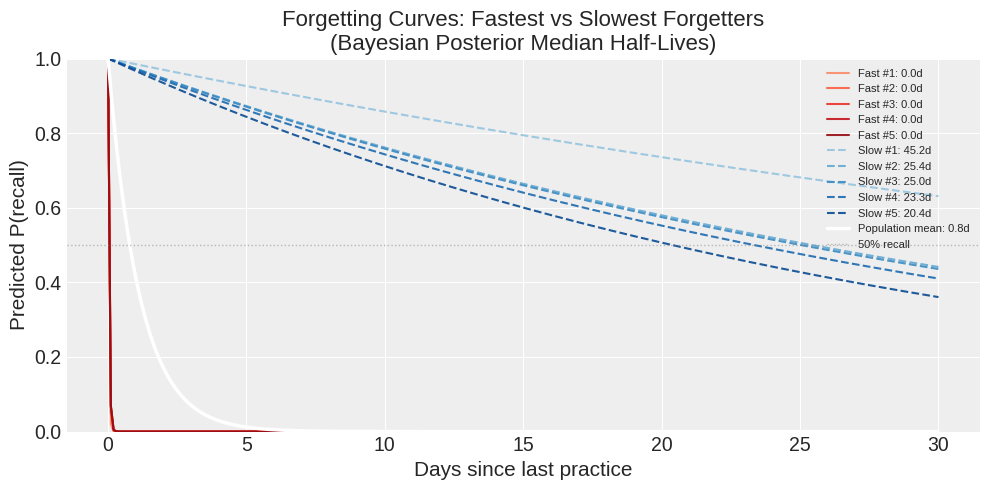

In [15]:
user_ids_list = list(user_cat.categories)
median_hl_all = median_hl  # shape (n_users,)

# Top 5 fastest forgetters (lowest half-life)
fast_idx = np.argsort(median_hl_all)[:5]
slow_idx = np.argsort(median_hl_all)[-5:][::-1]

print('=== TOP 5 FASTEST FORGETTERS ===')
for idx in fast_idx:
    lo, hi = hdi_hl[idx]
    nobs = obs_count[idx]
    print(f'  user={user_ids_list[idx]}  |  half-life={median_hl_all[idx]:.2f}d  '
          f'[94% HDI: {lo:.2f}–{hi:.2f}d]  |  n_obs={nobs}')

print()
print('=== TOP 5 SLOWEST FORGETTERS (Best Retention) ===')
for idx in slow_idx:
    lo, hi = hdi_hl[idx]
    nobs = obs_count[idx]
    print(f'  user={user_ids_list[idx]}  |  half-life={median_hl_all[idx]:.2f}d  '
          f'[94% HDI: {lo:.2f}–{hi:.2f}d]  |  n_obs={nobs}')

# ── Forgetting curves for extreme learners ────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
t_range = np.linspace(0, 30, 300)

cmap_fast = plt.cm.Reds(np.linspace(0.4, 0.9, 5))
cmap_slow = plt.cm.Blues(np.linspace(0.4, 0.9, 5))

for rank, idx in enumerate(fast_idx):
    hl_draws = halflife_flat[:, idx]
    hl_med   = np.median(hl_draws)
    ax.plot(t_range, 2**(-t_range/hl_med),
            color=cmap_fast[rank], lw=1.5, alpha=0.9,
            label=f'Fast #{rank+1}: {hl_med:.1f}d')

for rank, idx in enumerate(slow_idx):
    hl_draws = halflife_flat[:, idx]
    hl_med   = np.median(hl_draws)
    ax.plot(t_range, 2**(-t_range/hl_med),
            color=cmap_slow[rank], lw=1.5, alpha=0.9, ls='--',
            label=f'Slow #{rank+1}: {hl_med:.1f}d')

# Population mean
ax.plot(t_range, 2**(-t_range/pop_mean_hl),
        'w-', lw=2.5, label=f'Population mean: {pop_mean_hl:.1f}d')

ax.axhline(0.5, color='gray', ls=':', lw=1, alpha=0.5, label='50% recall')
ax.set_xlabel('Days since last practice')
ax.set_ylabel('Predicted P(recall)')
ax.set_title('Forgetting Curves: Fastest vs Slowest Forgetters\n(Bayesian Posterior Median Half-Lives)')
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig('../results/extreme_forgetting_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 14: Save the Trace (optional, for later analysis)

In [17]:
import os
os.makedirs('../results', exist_ok=True)

# Save the InferenceData object
trace.to_netcdf('../results/bayesian_hierarchical_trace.nc')
print('✅ Trace saved to ../results/bayesian_hierarchical_trace.nc')
print('   To reload: az.from_netcdf("../results/bayesian_hierarchical_trace.nc")')

✅ Trace saved to ../results/bayesian_hierarchical_trace.nc
   To reload: az.from_netcdf("../results/bayesian_hierarchical_trace.nc")
